# Comparing Activation Function and Initialization Choices

We compare sigmoid activation with weight initialization in $\mathcal{N}\left(0,1\right)$ with tanh activation and Glorot initialization and 4relu activation and He initialization. In the notes we have obtained the Glorot initialization. He initialization is a closely related prescription which is applicable for relu activation. In particular, we initialize weights in
\begin{equation*}
\texttt{He Normal} \quad : \quad \mathcal{N}\left(0,\sigma\right)\,,\qquad \sigma = \frac{1}{n_{in}}\,,
\end{equation*}
where $n_{in}$ is the number of neurons input to the given layer.

The optimizer is SGD with batch size 32 and learning rate 1e-3 in both cases.

We verify that hidden layer gradients in sigmoid are significantly suppressed as compared to relu all through training.

Instead of using $\texttt{model.fit}$ we have explicitly written out a training loop, following the code [here](https://keras.io/guides/writing_a_training_loop_from_scratch/).

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import backend as K

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train,y_train),(x_test,y_test)= fashion_mnist.load_data()

x_train, x_test = x_train/255., x_test/255.

In [3]:
def build_model(activation,kernel_initializer):
    model = keras.models.Sequential()
    model.add(Flatten(input_shape=[28,28]))
    model.add(Dense(300,activation=activation,kernel_initializer=kernel_initializer))
    model.add(Dense(300,activation=activation,kernel_initializer=kernel_initializer))
    model.add(Dense(300,activation=activation,kernel_initializer=kernel_initializer))
    model.add(Dense(300,activation=activation,kernel_initializer=kernel_initializer))
    model.add(Dense(10,activation='sigmoid'))
    return model

def label(i):
    if i%2==0:
        label = 'dW{}'.format(i//2+1)
    else:
        label = 'dB{}'.format(i//2+1)
    return label

# Training with Sigmoid, Random Normal Initialization

In [4]:
kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0,stddev=1.)
activation = 'sigmoid'

#kernel_initializer = tf.keras.initializers.he_normal()
#activation = 'relu'

optimizer = keras.optimizers.SGD(learning_rate=1e-2)

loss = tf.keras.losses.sparse_categorical_crossentropy

model = build_model(activation,kernel_initializer)

In [5]:
batch_size = 32

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [6]:
def train_model(activation,kernel_initializer,epochs):
    model = build_model(activation,kernel_initializer)
    grad_history = []
    for epoch in range(epochs):
        print('\nStart epoch {} of {}'.format(epoch,epochs))
        # iterate over minibatches
        for step, (x_batch,y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                y_pred = model(x_batch,training=True)
                loss_batch = tf.reduce_mean(loss(y_batch,y_pred))
            # retrieve gradients of trainable variables wrt the loss
            grads = tape.gradient(loss_batch, model.trainable_weights)
            # record these gradients
            grad_history.append(grads) 
            # run one step of gradient descent
            optimizer.apply_gradients(zip(grads,model.trainable_weights))
            # output every 200 batches
            if step % 200 == 0:
                print(
                    'Training loss for one batch at step {}: {}'.format(step,loss_batch)
                )
    del model
    return grad_history

In [7]:
epochs = 1
kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0,
                                                        stddev=1.,
                                                        seed=42)
activation = 'sigmoid'
grad_history = train_model(activation,kernel_initializer,epochs)


Start epoch 0 of 1
Training loss for one batch at step 0: 2.792067766189575
Training loss for one batch at step 200: 2.0094969272613525
Training loss for one batch at step 400: 1.7057669162750244
Training loss for one batch at step 600: 1.4914042949676514
Training loss for one batch at step 800: 1.569305658340454
Training loss for one batch at step 1000: 1.235703945159912
Training loss for one batch at step 1200: 1.3080089092254639
Training loss for one batch at step 1400: 0.978909969329834
Training loss for one batch at step 1600: 0.9254611730575562
Training loss for one batch at step 1800: 0.9056956768035889


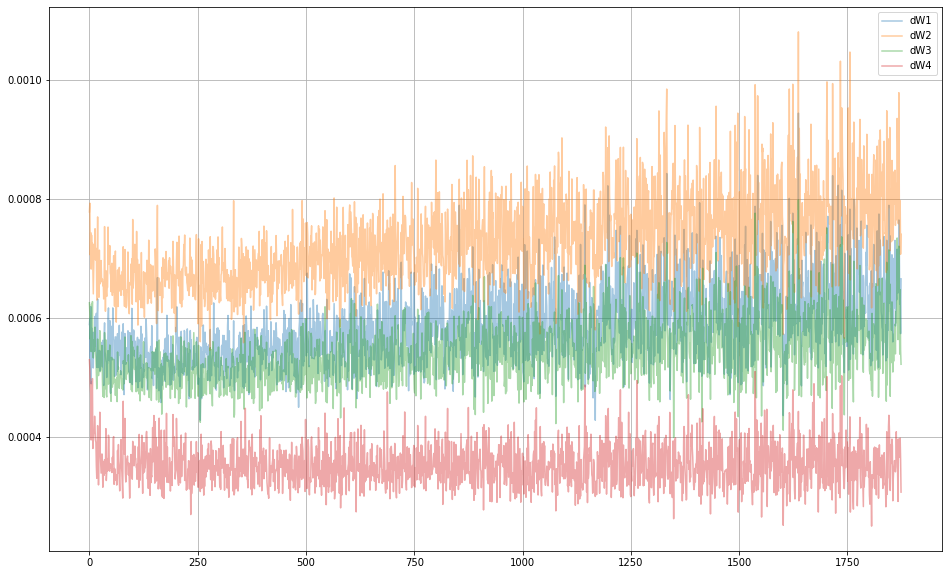

In [8]:
sigmoid_grad_history = []
for grad_epoch in grad_history:
    sigmoid_grad_history.append([np.mean(np.abs(g.numpy())) for g in grad_epoch])
sigmoid_grad_history = np.asarray(sigmoid_grad_history).T

plt.figure(figsize=(16,10))
for i,g in enumerate(sigmoid_grad_history[:-2]):
    if i%2==0:
        plt.plot(g,label=label(i),alpha=0.4)
plt.legend(loc='best')
plt.grid('both')
plt.show()

In [9]:
epochs = 1
kernel_initializer = tf.keras.initializers.GlorotNormal(seed=42)
activation = 'tanh'
grad_history = train_model(activation,kernel_initializer,epochs)


Start epoch 0 of 1
Training loss for one batch at step 0: 2.3711843490600586
Training loss for one batch at step 200: 0.7087228298187256
Training loss for one batch at step 400: 0.6704463958740234
Training loss for one batch at step 600: 0.7150217294692993
Training loss for one batch at step 800: 0.7364635467529297
Training loss for one batch at step 1000: 0.5553878545761108
Training loss for one batch at step 1200: 0.2359018474817276
Training loss for one batch at step 1400: 0.741060733795166
Training loss for one batch at step 1600: 0.5343486070632935
Training loss for one batch at step 1800: 0.469448983669281


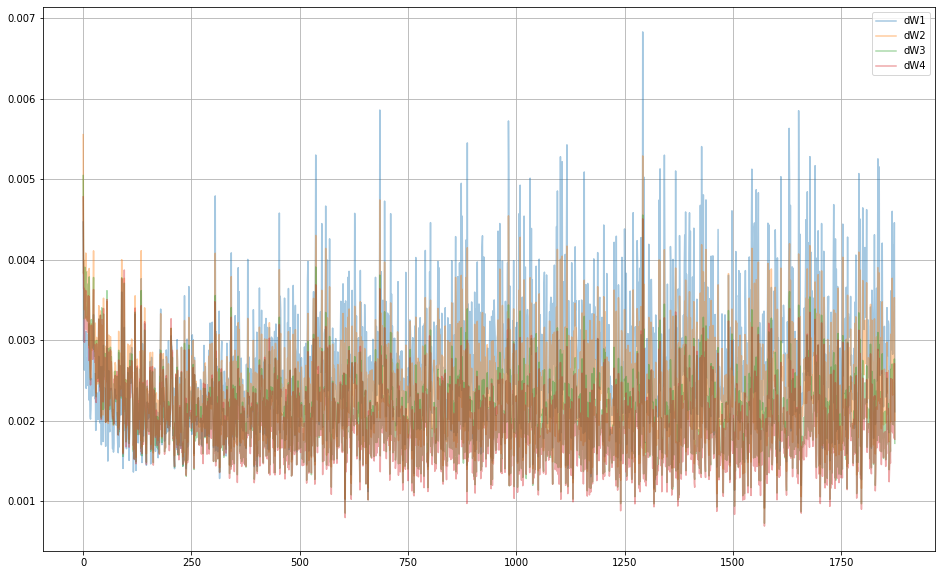

In [10]:
tanh_grad_history = []
for grad_epoch in grad_history:
    tanh_grad_history.append([np.mean(np.abs(g.numpy())) for g in grad_epoch])
tanh_grad_history = np.asarray(tanh_grad_history).T

plt.figure(figsize=(16,10))
for i,g in enumerate(tanh_grad_history[:-2]):
    if i%2==0:
        plt.plot(g,label=label(i),alpha=0.4)
plt.legend(loc='best')
plt.grid('both')
plt.show()

In [ ]:
epochs = 1
kernel_initializer = tf.keras.initializers.HeNormal(seed=42)
activation = 'relu'
grad_history = train_model(activation,kernel_initializer,epochs)


Start epoch 0 of 1
Training loss for one batch at step 0: 2.49637508392334
Training loss for one batch at step 200: 0.5582758188247681
Training loss for one batch at step 400: 0.6039670705795288
Training loss for one batch at step 600: 0.5240426063537598
Training loss for one batch at step 800: 0.6737096905708313
Training loss for one batch at step 1000: 0.3329494893550873


In [ ]:
relu_grad_history = []
for grad_epoch in grad_history:
    relu_grad_history.append([np.mean(np.abs(g.numpy())) for g in grad_epoch])
relu_grad_history = np.asarray(relu_grad_history).T

plt.figure(figsize=(16,10))
for i,g in enumerate(relu_grad_history[:-2]):
    if i%2==0:
        plt.plot(g,label=label(i),alpha=0.2)
plt.legend(loc='best')
plt.grid('both')
plt.show()

# Comparing Gradients

In [15]:
def return_grad_statistics(grad_hist):
    mean_grads = np.mean(grad_hist[:-2],axis=0)
    std_grads = np.std(grad_hist[:2],axis=0)
    lb = mean_grads-std_grads
    ub = mean_grads+std_grads
    return mean_grads,std_grads,lb,ub

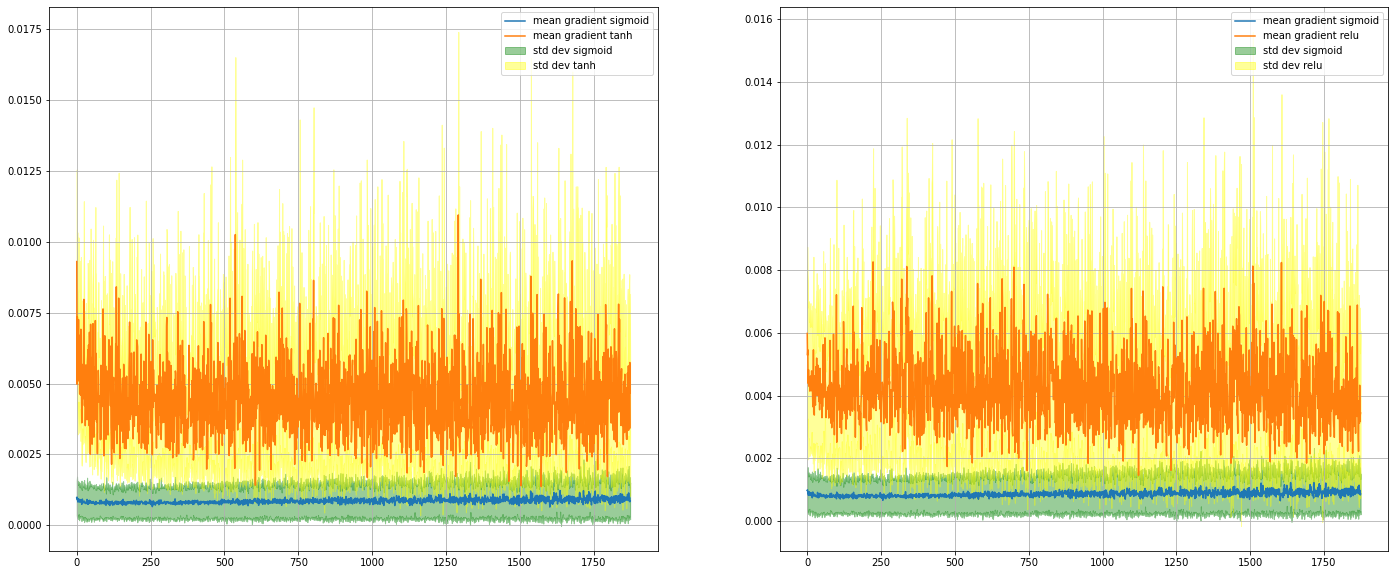

In [17]:
[s_mean,s_std,s_lb,s_ub] = return_grad_statistics(sigmoid_grad_history)
[t_mean,t_std,t_lb,t_ub] = return_grad_statistics(tanh_grad_history)
[r_mean,r_std,r_lb,r_ub] = return_grad_statistics(relu_grad_history)

x_axis = range(len(s_mean))

plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
plt.plot(s_mean,label='mean gradient sigmoid')
plt.fill_between(x_axis,s_lb,s_ub,color='green',alpha=0.4,label='std dev sigmoid')

plt.plot(t_mean,label='mean gradient tanh')
plt.fill_between(x_axis,t_lb,t_ub,color='yellow',alpha=0.4,label='std dev tanh')
plt.legend(loc='best')
plt.grid('both')

plt.subplot(1,2,2)

plt.plot(s_mean,label='mean gradient sigmoid')
plt.fill_between(x_axis,s_lb,s_ub,color='green',alpha=0.4,label='std dev sigmoid')

plt.plot(r_mean,label='mean gradient relu')
plt.fill_between(x_axis,r_lb,r_ub,color='yellow',alpha=0.4,label='std dev relu')
plt.legend(loc='best')
plt.grid('both')
plt.show()

We see that gradients in both the tanh+Glorot and relu+He initialization are much larger than in the sigmoid+RandomNormal initialization.